In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, PercentFormatter
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats as smstats
import sys
sys.path.append("../src/utils")
from evaluation_utils import get_xcap_data
from annovar_utils import *

D_original_variants = "/cluster/u/rrastogi/ECNN/results/original_dataset/preprocess/collate/total_combined.tsv"
D_original_train_variants = "/cluster/u/rrastogi/ECNN/results/original_dataset/xcap/train_set/filtered_train.tsv"
train_features = "/cluster/u/rrastogi/ECNN/results/original_dataset/xcap/features/train.features"

In [2]:
def get_feature_values(feature_name, divide_by_label=True):
    feature_values = features[:, feature_names.index(feature_name)]
    if divide_by_label:
        benign_feature_values = feature_values[labels == 0]
        path_feature_values = feature_values[labels == 1]
        return benign_feature_values, path_feature_values
    else:
        return feature_values

def get_histogram_weights(arr):
    return np.ones_like(arr) / arr.size

In [3]:
feature_names, features, labels = get_xcap_data(train_features)

# 2A: RVIS

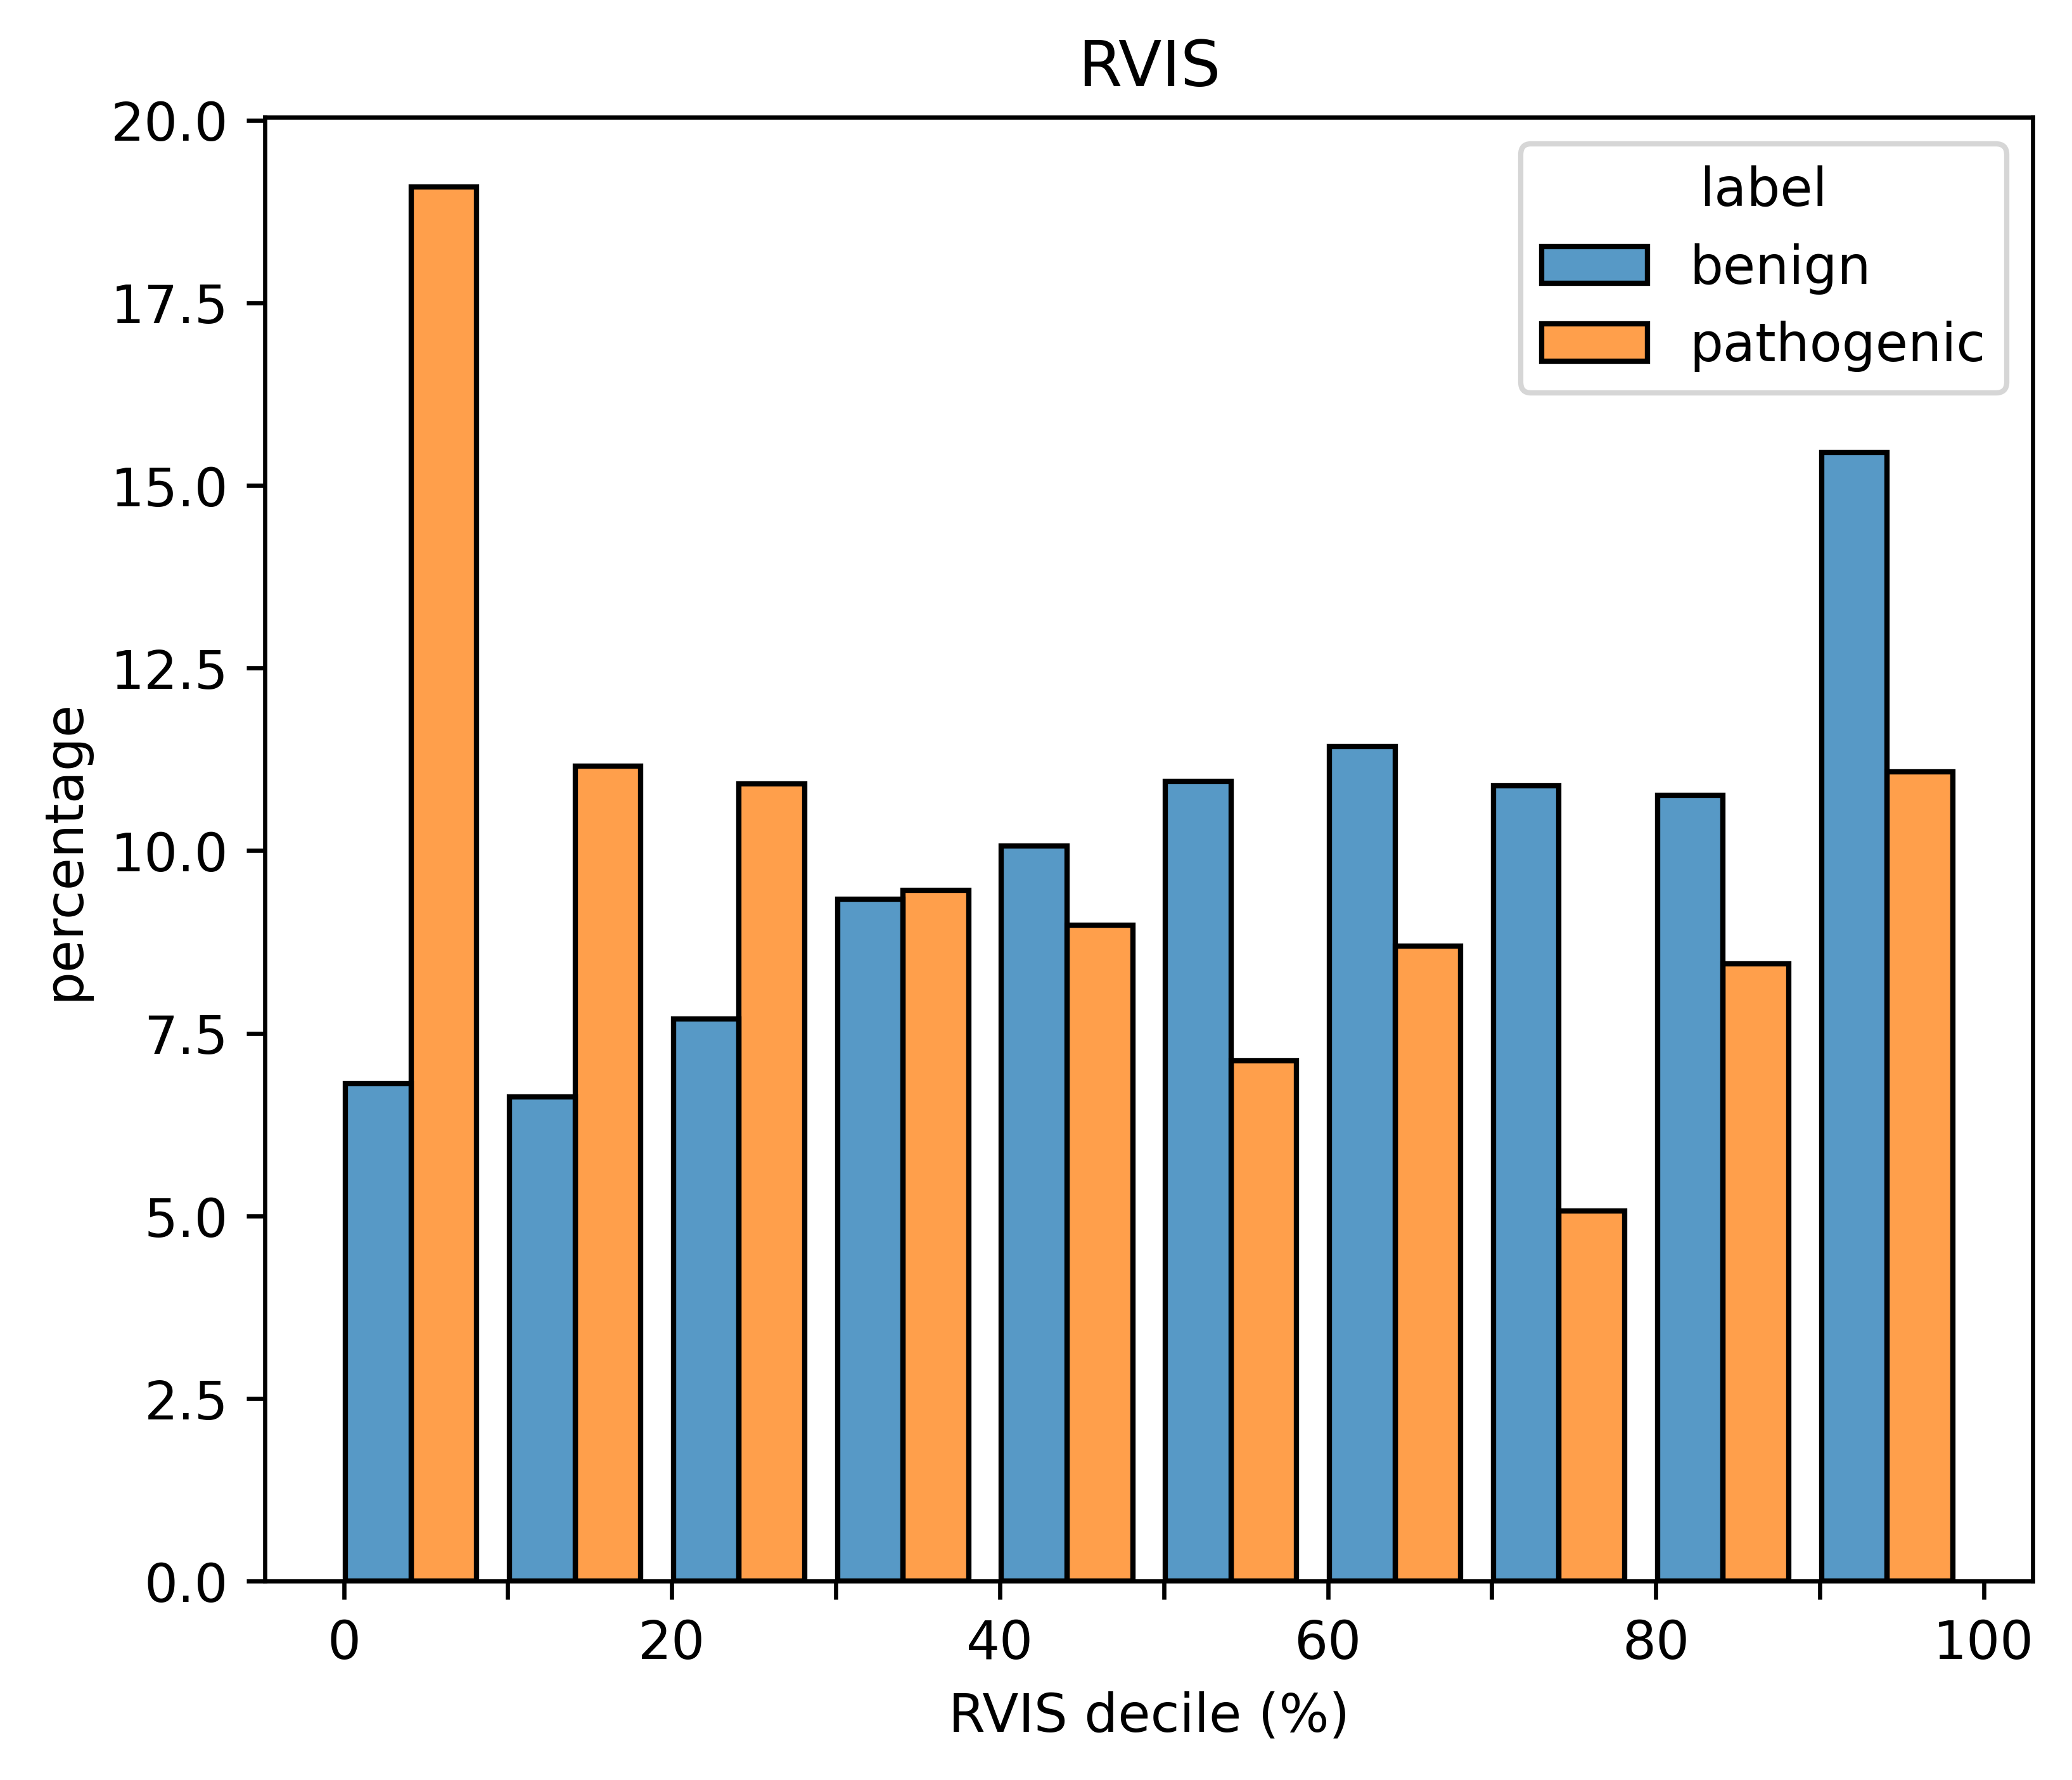

In [4]:
benign_rvis, path_rvis = get_feature_values("rvis")
# We assign a default score of 50.0 to those variants without RVIS values.
# Let's remove them when plotting.

benign_rvis = benign_rvis[benign_rvis != 50.0]
path_rvis = path_rvis[path_rvis != 50.0]

rvis_labels = ["benign"] * len(benign_rvis) + ["pathogenic"] * len(path_rvis)
rvis_values = np.concatenate((benign_rvis, path_rvis))
rvis_df = pd.DataFrame({
    "label": rvis_labels,
    "RVIS decile (%)": rvis_values
})

sns.reset_defaults()
plt.figure(figsize=(6, 5), dpi=600)
ax = sns.histplot(data=rvis_df, x="RVIS decile (%)", hue="label",
                  multiple="dodge", shrink=0.8, binwidth=10, binrange=(0, 100), 
                  stat="probability", common_norm=False)
ax.set(xticks=np.arange(0, 110, 10))
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, symbol=None))
ax.set(ylabel="percentage")
for label in ax.xaxis.get_ticklabels()[1: : 2]:
    label.set_visible(False)
ax.set(title="RVIS")
plt.show()

# 2B: Relative variant location in CDS

Mean benign truncation %: 48.04464853013683
Mean pathogenic truncation %: 51.186225190332024
one-sided p-value: 8.022060167677497e-60


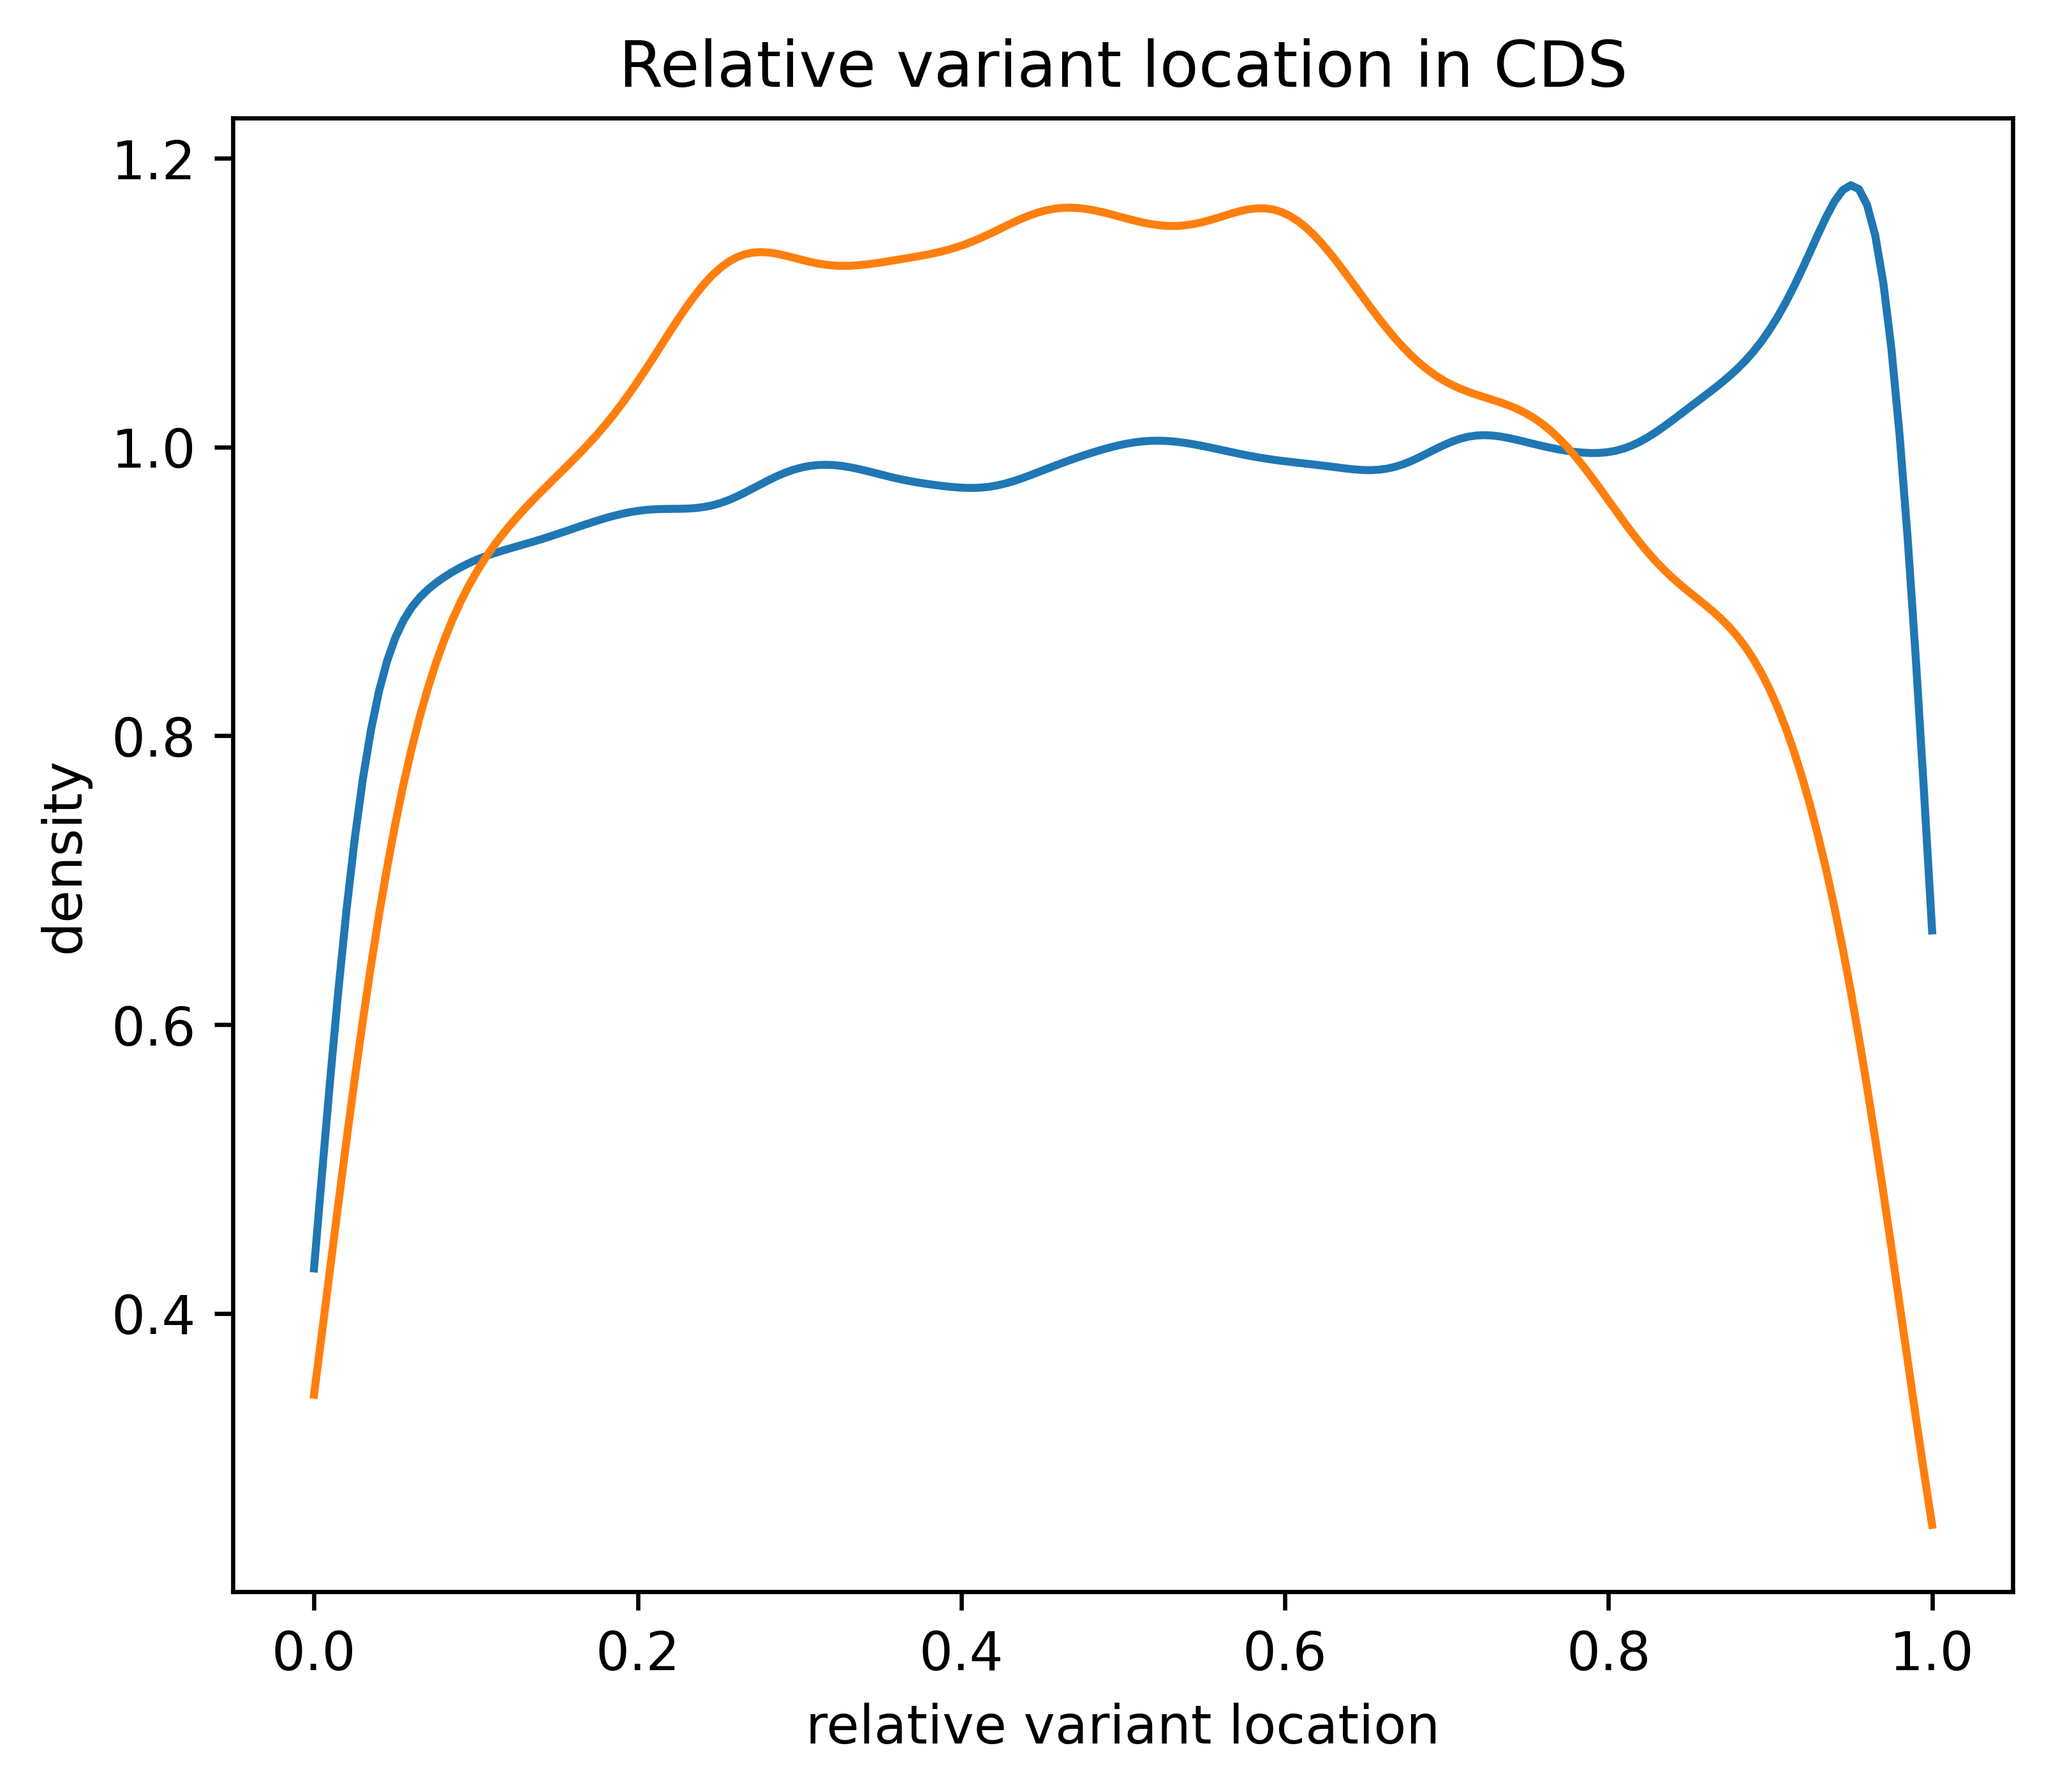

In [5]:
benign_location_in_cds, path_location_in_cds = get_feature_values("relative_location_in_cds")
print("Mean benign truncation %: {}".format(100 * (1 - np.mean(benign_location_in_cds))))
print("Mean pathogenic truncation %: {}".format(100 * (1 - np.mean(path_location_in_cds))))

statistic, pvalue = stats.ttest_ind(benign_location_in_cds, path_location_in_cds, equal_var=False)
print("one-sided p-value: {}".format(pvalue / 2))

sns.reset_defaults()
plt.figure(figsize=(6, 5), dpi=600)
ax = sns.kdeplot(benign_location_in_cds, label="benign", clip=[0.0, 1.0])
sns.kdeplot(path_location_in_cds, label="pathogenic", clip=[0.0, 1.0])
ax.set(xlabel="relative variant location")
ax.set(ylabel="density")
ax.set(title="Relative variant location in CDS")
plt.show()

# 2C: Num exons

Mean benign num exons: 15.544124753695876
Mean path num exons: 25.148352617377718


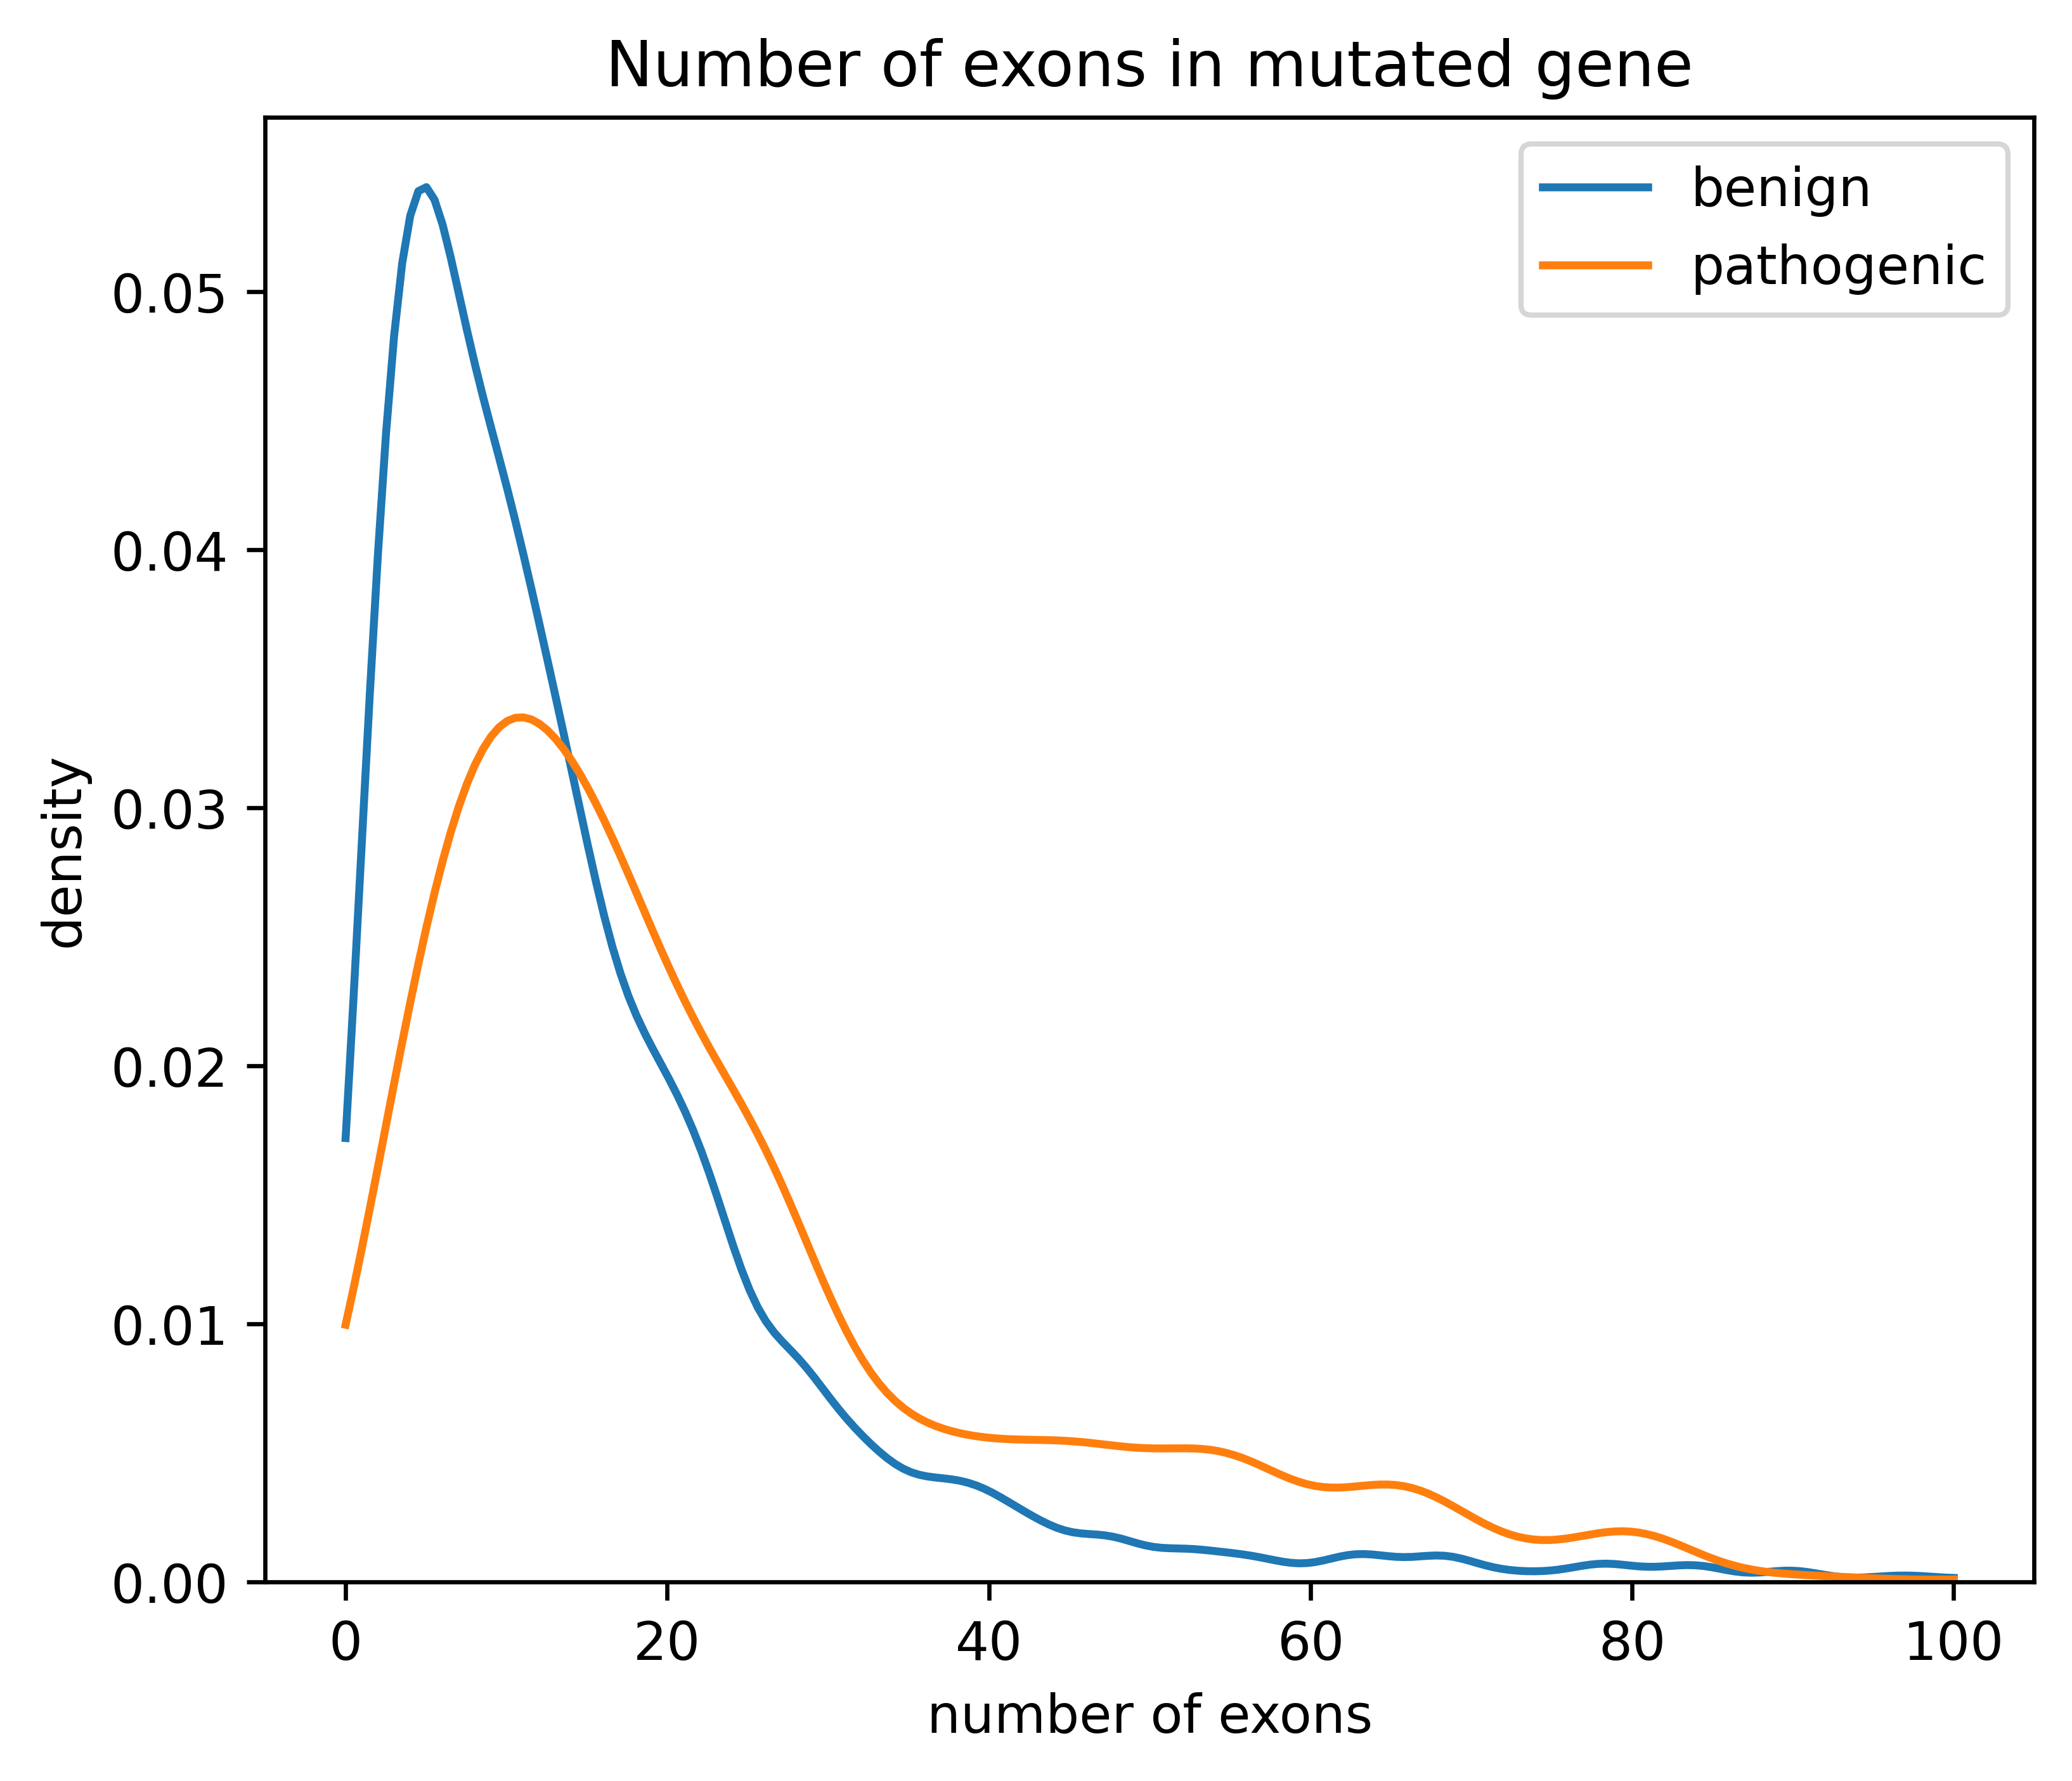

In [6]:
benign_num_exons, path_num_exons = get_feature_values("num_exons")
print("Mean benign num exons: {}".format(np.mean(benign_num_exons)))
print("Mean path num exons: {}".format(np.mean(path_num_exons)))

tstat, pvalue, df = smstats.weightstats.ttest_ind(benign_num_exons, path_num_exons, alternative='smaller',
                                                  usevar='unequal')

sns.reset_defaults()
plt.figure(figsize=(6, 5), dpi=600)
ax = sns.kdeplot(benign_num_exons, label="benign", clip=[0, 100])
sns.kdeplot(path_num_exons, label="pathogenic", clip=[0, 100])
ax.set(xlabel="number of exons")
ax.set(ylabel="density")
ax.set(title="Number of exons in mutated gene")
plt.legend()
plt.show()

# 2D: Stop Codon

Stop codon: TAA, p value=7.234358695869213e-19
Stop codon: TAG, p value=2.6830767056069274e-06
Stop codon: TGA, p value=3.4356725333062155e-33


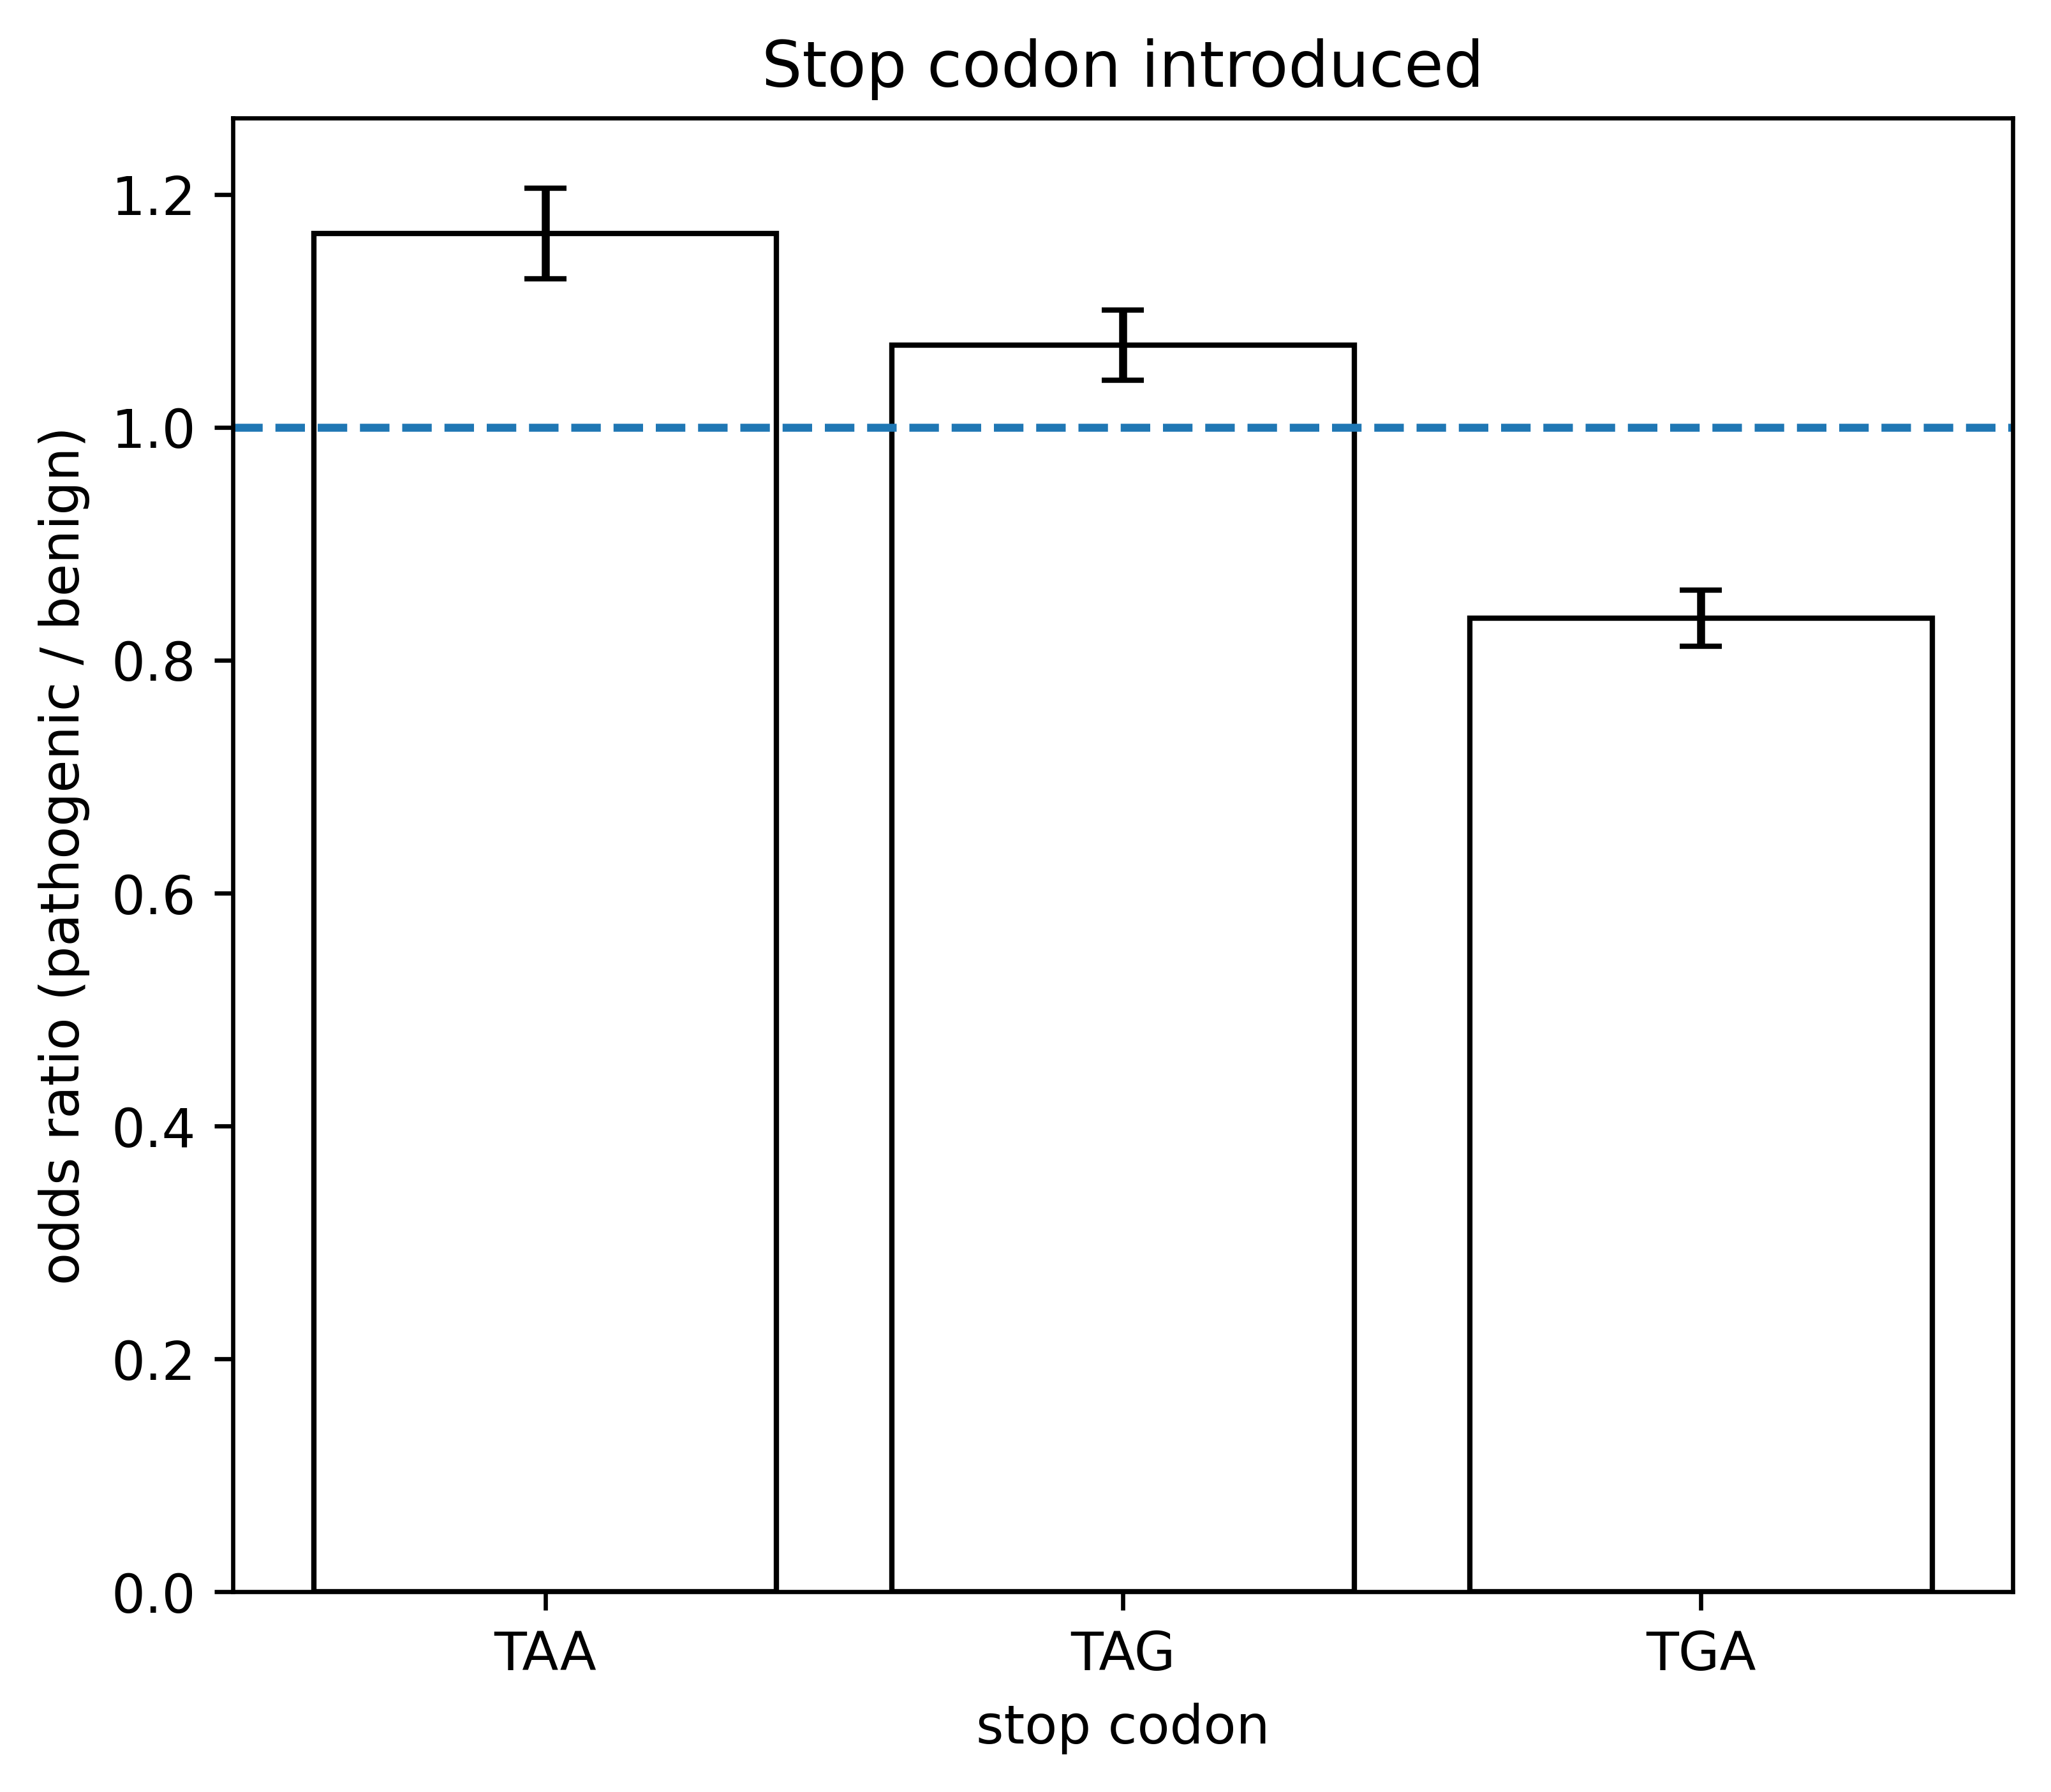

In [8]:
stop_codons = ["TAA", "TAG", "TGA"]
ors = []
or_errs = []
for stop_codon in stop_codons:
    benign_stop_codon, path_stop_codon = get_feature_values(stop_codon)
    table = sm.stats.Table2x2([
        [np.sum(path_stop_codon), np.sum(benign_stop_codon)],
        [np.size(path_stop_codon) - np.sum(path_stop_codon), 
         np.size(benign_stop_codon) - np.sum(benign_stop_codon)]
    ])
    ors.append(table.oddsratio)
    or_errs.append(table.oddsratio - table.oddsratio_confint()[0])
    print("Stop codon: {}, p value={}".format(stop_codon, table.oddsratio_pvalue()))

plt.figure(figsize=(6, 5), dpi=600)
plt.bar(range(len(stop_codons)), ors, yerr=or_errs, 
        tick_label=stop_codons, fill=False, capsize=4)
plt.axhline(1.0, linestyle='--')
plt.xlabel("stop codon")
plt.ylabel("odds ratio (pathogenic / benign)")
plt.title("Stop codon introduced")
plt.show()

# 2E: Alternative translation reinitiation

In [9]:
def get_alternative_translation_reinitiation_table(max_dist):
    location_in_cds = get_feature_values("distance_from_cds_start",
                                      divide_by_label=False)
    dist_to_next_start = get_feature_values("dist_to_next_start_codon",
                                         divide_by_label=False)
    # Isolate variants in the first 100 bp of the sequence
    dist_to_next_start = dist_to_next_start[location_in_cds <= 100]
    labels_subset = labels[location_in_cds <= 100]
    
    table = np.zeros((2, 2))
    for i in range(dist_to_next_start.shape[0]):
        dist = dist_to_next_start[i]
        label = labels_subset[i]
        exposure = int(dist <= max_dist)
        table[1 - exposure][1 - label] += 1
    return sm.stats.Table2x2(table)

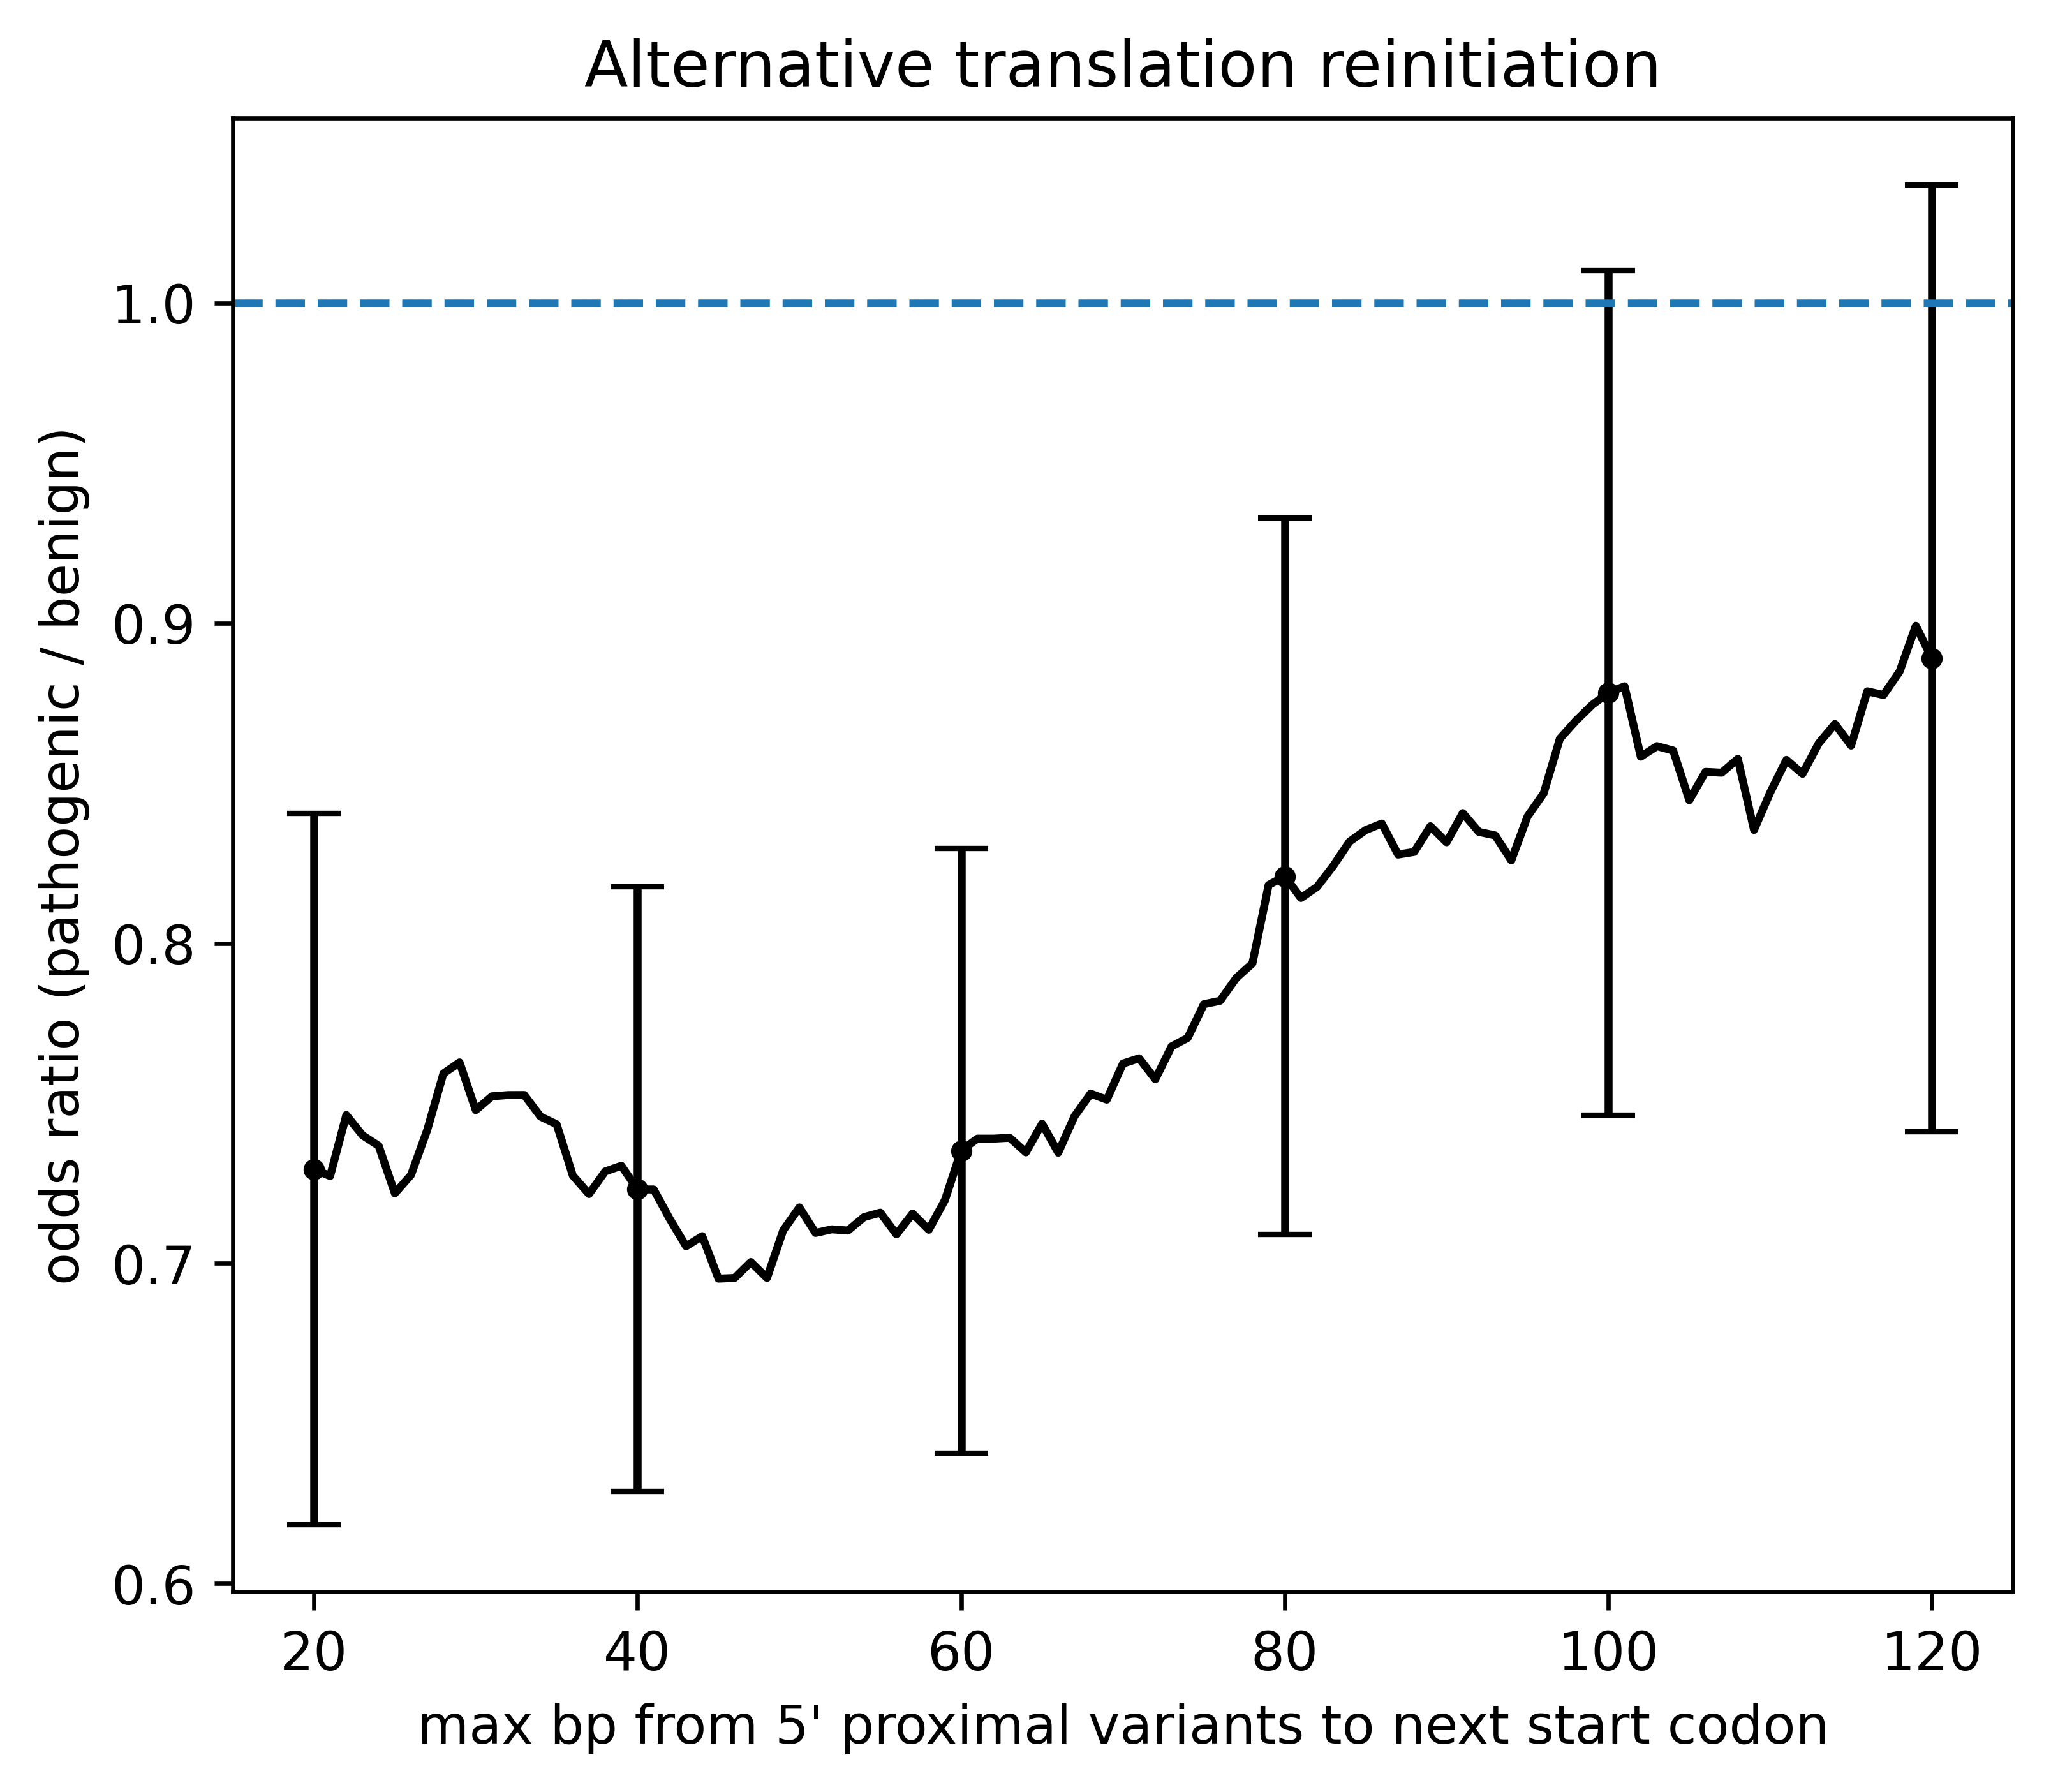

In [10]:
full_ors = []
partial_ors = []
partial_or_errs = []
partial_max_dist = []

max_dist_to_next_start_thresholds = list(range(20, 121))
for max_dist in max_dist_to_next_start_thresholds:
    table = get_alternative_translation_reinitiation_table(max_dist)
    full_ors.append(table.oddsratio)
    if max_dist % 20 == 0:
        partial_max_dist.append(max_dist)
        partial_ors.append(table.oddsratio)
        partial_or_errs.append(table.oddsratio - table.oddsratio_confint()[0])
    
    
plt.figure(figsize=(6, 5), dpi=600)
plt.plot(max_dist_to_next_start_thresholds, full_ors, color='k')
plt.errorbar(partial_max_dist, partial_ors, yerr=partial_or_errs,
             capsize=5, color='k', fmt='.')
plt.axhline(1.0, linestyle='--')
plt.xlabel("max bp from 5' proximal variants to next start codon")
plt.ylabel("odds ratio (pathogenic / benign)")
plt.title("Alternative translation reinitiation")
plt.show()

# 2F: Downstream phyloP

In [11]:
benign_downstream_phylop, path_downstream_phylop = get_feature_values("downstream_phylop")

In [12]:
print(np.mean(benign_downstream_phylop))
print(np.mean(path_downstream_phylop))

2.256917942037823
3.2198864901795914


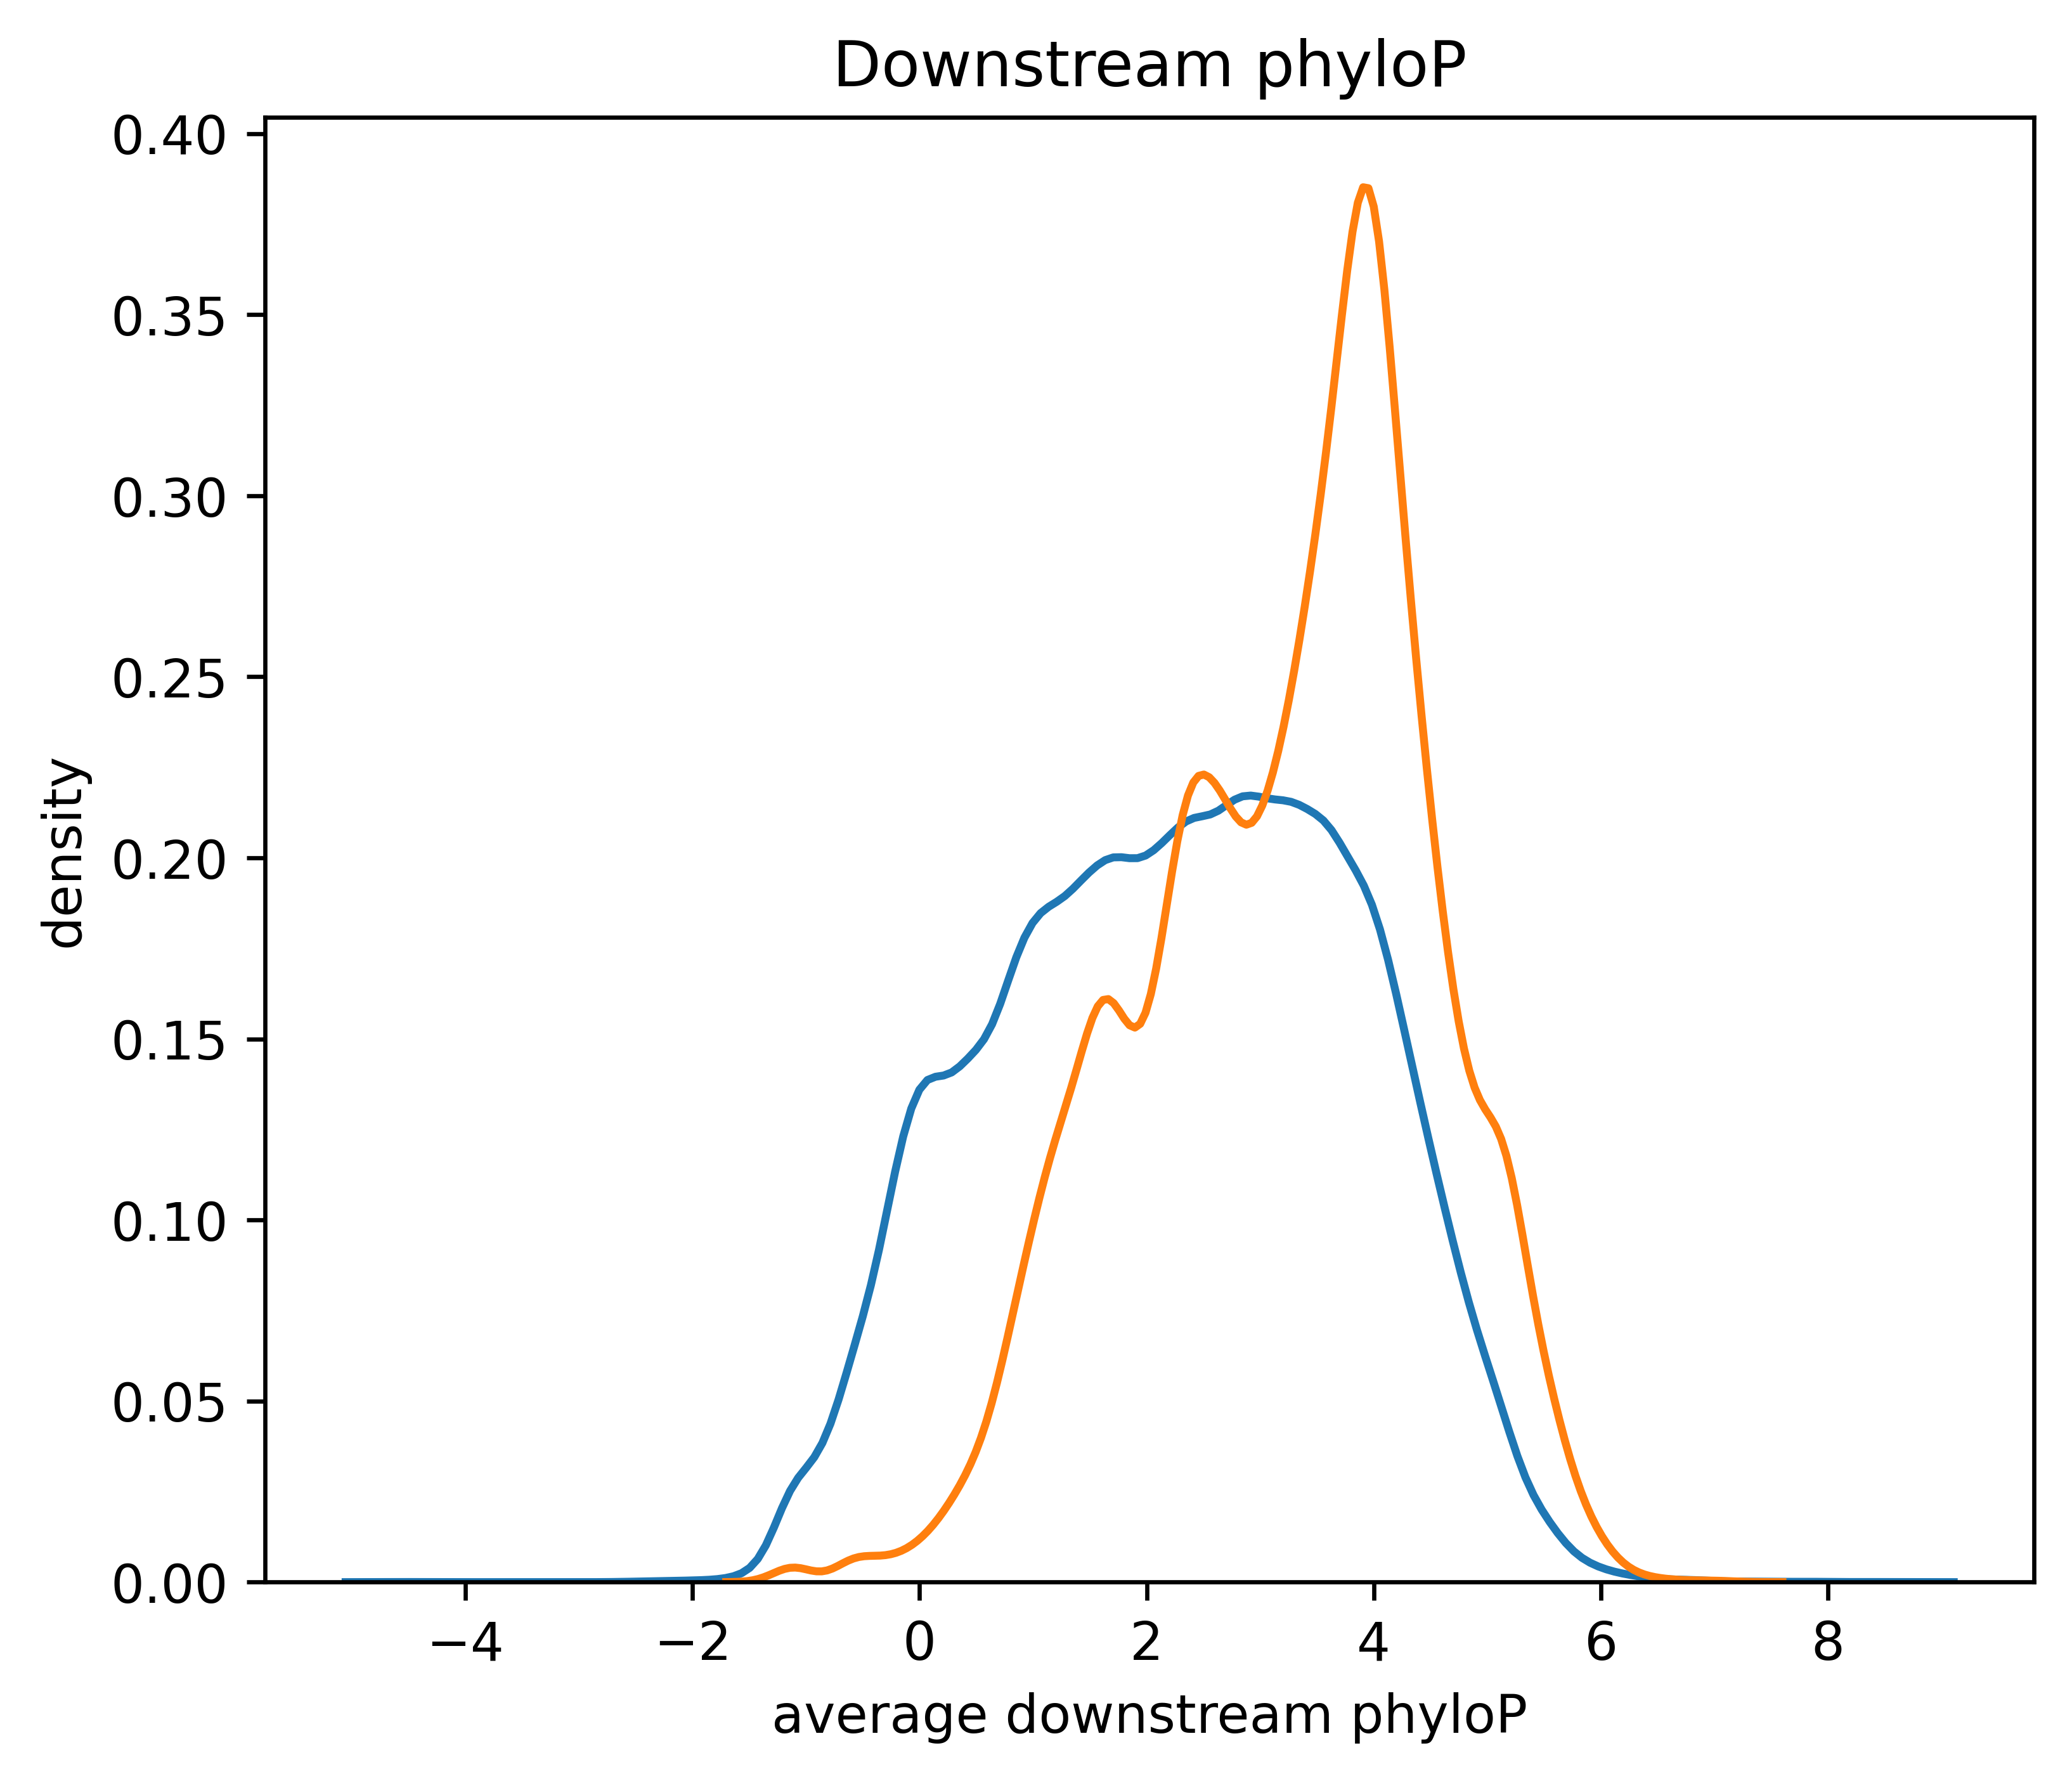

In [13]:
sns.reset_defaults()
plt.figure(figsize=(6, 5), dpi=600)
ax = sns.kdeplot(benign_downstream_phylop, label="benign")
sns.kdeplot(path_downstream_phylop, label="pathogenic")
ax.set(xlabel="average downstream phyloP")
ax.set(ylabel="density")
ax.set(title="Downstream phyloP")
plt.show()